# Time Series

In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns

# Import ARIMA model.
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
from fbprophet import Prophet

import statsmodels.api as sm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, recall_score, f1_score, precision_score, roc_auc_score, plot_roc_curve
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

In [71]:
# read file and process data
def process_df(file_path):
    # read data with probability
    
    fire = pd.read_csv(file_path)
    
    # drop the unnamed 0 column
    fire.drop(columns = 'Unnamed: 0', inplace = True)
    
    # change date columns to datetime
    fire['date'] = pd.to_datetime(fire['date'])
    # reframe the time format
    fire['date'] = fire['date'].dt.strftime('%Y-%m-%d')
    
    # change date columns to datetime
    fire['date'] = pd.to_datetime(fire['date'])
    
    # drop null values
    fire.dropna(inplace=True)
    
    # set time as index to explore the timeseries
    fire.set_index('date', inplace=True)
    
    fire.sort_index(inplace=True)
    
    return fire

In [72]:
# read processed dataset 
file_path = 'timeseries.csv'
fire = process_df(file_path)
fire.head()

,content,relevant,proba
date,,,
2020-07-01,el dorado hills california,0.0,0.095629
2020-07-01,aaahhhmmmm justrelax wine malbec queyico san j...,0.0,0.095629
2020-07-01,taco tuesday vegan youdidntknow youwouldntknow...,0.0,0.104460
2020-07-01,color blocking berkeley california,0.0,0.093061
2020-07-01,batch roma tomatoes picked tree including roma...,0.0,0.098034


In [73]:
fire.isnull().sum()

content     0
relevant    0
proba       0
dtype: int64

In [74]:
# resampling with day
# avg probablity of relevant post by day
fire.resample('D').mean()

,relevant,proba
date,,
2020-07-01,0.127013,0.180310
2020-07-02,0.145870,0.143383
2020-07-03,0.219365,0.214685
2020-07-04,0.175732,0.184212
2020-07-05,0.182558,0.195138
...,...,...
2020-12-26,0.055637,0.107657
2020-12-27,0.087034,0.128325
2020-12-28,0.102204,0.132644


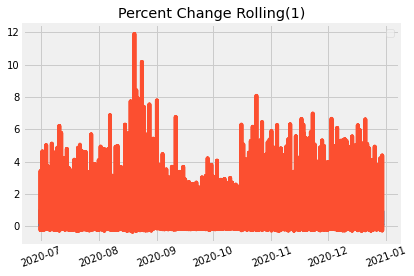

In [78]:
# rolling 7 days proba changes
plt.plot(fire.proba)
plt.plot(fire.proba.pct_change().rolling(7).mean())
plt.xticks(rotation = 20)
plt.title('Percent Change Rolling(1)')
plt.legend()

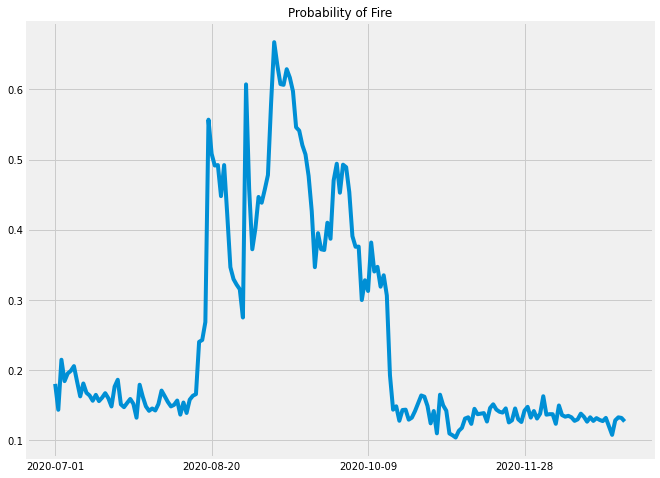

In [82]:
# plot fire data probability 

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(10,8))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=12)
    plt.xlabel(xlab, fontsize=10)
    plt.ylabel(ylab, fontsize=10)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=10)
    plt.xticks(df.index[0::steps], fontsize=10);
    
    
# Generate a time plot of our data.
plot_series(fire.resample('D').mean(),
            ['proba'],
            title = "Probability of Fire",
            steps = 50)

In [84]:
# different by 1 and 2
fire['first_diff_proba'] = fire.proba.diff(1)
fire['second_diff_proba'] = fire.proba.diff(1).diff(1)

In [85]:
# average by day
fire2 = fire.resample('D').mean()
fire2.head()

,relevant,proba,first_diff_proba,second_diff_proba
date,,,,
2020-07-01,0.127013,0.180310,5.968941e-19,-0.000035
2020-07-02,0.145870,0.143383,-1.099170e-05,-0.000008
2020-07-03,0.219365,0.214685,9.461838e-06,0.000034
2020-07-04,0.175732,0.184212,1.123646e-03,0.000288
2020-07-05,0.182558,0.195138,-9.632263e-04,-0.000264


In [86]:
# Import Augmented Dickey-Fuller test.
# to see if the data is stationary
# h0 no stationary , h1 stationary
from statsmodels.tsa.stattools import adfuller

# Run ADF test on original (non-differenced!) data.
adfuller(fire2['proba'])

(-1.705881702235252,
 0.42808462330862995,
 1,
 181,
 {'1%': -3.467004502498507,
  '5%': -2.8776444997243558,
  '10%': -2.575355189707274},
 -555.9035857286514)

In [87]:
# intepret adfuller 
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value', 'used_lag', 'samples'])
    return dfoutput

In [88]:
# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(fire2.proba))

Test Statistic     -1.705882
p-value             0.428085
used_lag            1.000000
samples           181.000000
dtype: float64

In [36]:
# first diff probability adulffuler test
interpret_dftest(adfuller(fire2['first_diff_proba']))

Test Statistic   -1.388183e+01
p-value           6.190853e-26
used_lag          0.000000e+00
samples           1.820000e+02
dtype: float64

ARIMA

In [37]:
# Create train-test split.
y_train, y_test = train_test_split(fire2['proba'],
                                   test_size = 0.25,
                                   shuffle = False) # Shuffle = False is IMPORTANT!

In [39]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):
        
        # Insert try and except statements.
        try:
            
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting to fit ARIMA({p},1,{q})')
            
            # Instantiate ARIMA model.
            arima = ARIMA(endog = y_train.astype(float).dropna(), # endog = Y variable
                          order = (p,1,q)) # values of p, d, q
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit ARIMA(0,1,0)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.54371D+00    |proj g|=  1.93179D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     11      1     0     0   1.887D-06  -1.544D+00
  F =  -1.5437076044161462     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(0,1,0) is: -415.88846840119174
Attempting to fit ARIMA(0,1,1)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =    

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4     11      1     0     0   4.441D-08  -1.556D+00
  F =  -1.5563610286960023     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(0,1,1) is: -417.33019980531265
Attempting to fit ARIMA(0,1,2)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55681D+00    |proj g|=  1.55789D-03


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.55681D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     13      1     0     0   4.441D-08  -1.557D+00
  F =  -1.5568104660271511     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(0,1,2) is: -415.4524467593851
Attempting to fit ARIMA(0,1,3)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.56455D+00    |proj g|=  2.45088D-03

At iterate    5    f= -1.56455D+00    |proj g|=  3.6

 This problem is unconstrained.



At iterate    5    f= -1.56483D+00    |proj g|=  3.39728D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     15      1     0     0   8.882D-08  -1.565D+00
  F =  -1.5648264262956757     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(0,1,4) is: -413.63278795242377
Attempting to fit ARIMA(1,1,0)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55489D+00    |proj g|=  1.01450D-01

At iterate    5    f= -1.55490D+00    |proj g|=  2.

 This problem is unconstrained.
 This problem is unconstrained.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55616D+00    |proj g|=  9.47586D-02

At iterate    5    f= -1.55617D+00    |proj g|=  4.73223D-02

At iterate   10    f= -1.55620D+00    |proj g|=  4.30807D-03

At iterate   15    f= -1.55621D+00    |proj g|=  4.61548D-02

At iterate   20    f= -1.55650D+00    |proj g|=  8.79912D-02

At iterate   25    f= -1.55655D+00    |proj g|=  1.33671D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     31      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55920D+00    |proj g|=  1.47986D-01

At iterate    5    f= -1.55922D+00    |proj g|=  3.77943D-02

At iterate   10    f= -1.55926D+00    |proj g|=  2.83029D-02

At iterate   15    f= -1.55926D+00    |proj g|=  2.68319D-03

At iterate   20    f= -1.55929D+00    |proj g|=  2.72133D-03

At iterate   25    f= -1.55932D+00    |proj g|=  1.55115D-02

At iterate   30    f= -1.55932D+00    |proj g|=  5.77316D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.56173D+00    |proj g|=  1.41155D-01

At iterate    5    f= -1.56176D+00    |proj g|=  2.90406D-02

At iterate   10    f= -1.56178D+00    |proj g|=  1.71195D-02

At iterate   15    f= -1.56178D+00    |proj g|=  1.19725D-02

At iterate   20    f= -1.56194D+00    |proj g|=  1.50650D-01

At iterate   25    f= -1.56326D+00    |proj g|=  8.93231D-02

At iterate   30    f= -1.56469D+00    |proj g|=  4.89175D-03

At iterate   35    f= -1.56470D+00    |proj g|=  2.22045D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.56458D+00    |proj g|=  1.24719D-01

At iterate    5    f= -1.56463D+00    |proj g|=  1.07386D-01

At iterate   10    f= -1.56469D+00    |proj g|=  6.28830D-04

At iterate   15    f= -1.56469D+00    |proj g|=  1.53739D-03

At iterate   20    f= -1.56477D+00    |proj g|=  3.89641D-02

At iterate   25    f= -1.56513D+00    |proj g|=  5.09941D-02

At iterate   30    f= -1.56538D+00    |proj g|=  6.65928D-02

At iterate   35    f= -1.56578D+00    |proj g|=  1.74365D-02

At iterate   40    f= -1.56601D+00    |proj g|=  2.46484D-02

At iterate   45    f= -1.56645D+00    |proj g|=  3.16854D-02

At iterate   50    f= -1.56649D+00    |proj g|=  3.16338D-03

At iterate   55    f= -1.56650D+00    |proj g|=  1.76348D-04

At iterate   60    f= -1.56650D+00    |proj g|=  9.13558D-04
  ys=-3.548E-09  -gs= 8.501


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     63    101      1     1     0   3.020D-04  -1.566D+00
  F =  -1.5664962659504955     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(1,1,4) is: -412.08698433853476
Attempting to fit ARIMA(2,1,0)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55856D+00    |proj g|=  1.13750D-01

At iterate    5    f= -1.55858D+00    |proj g|=  3.20188D-02

At iterate   10    f= -1.55859D+00    |proj g|=  5.

 This problem is unconstrained.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.56044D+00    |proj g|=  2.36710D-02

At iterate    5    f= -1.56054D+00    |proj g|=  7.14762D-04

At iterate   10    f= -1.56058D+00    |proj g|=  7.51155D-04

At iterate   15    f= -1.56058D+00    |proj g|=  1.19904D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     26      1     0     0   1.554D-07  -1.561D+00
  F =  -1.5605826243835381     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC 

 This problem is unconstrained.


The AIC for ARIMA(2,1,2) is: -412.49684471213266
Attempting to fit ARIMA(2,1,3)


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.56411D+00    |proj g|=  1.07867D-01

At iterate    5    f= -1.56415D+00    |proj g|=  9.06482D-02

At iterate   10    f= -1.56417D+00    |proj g|=  2.23503D-03

At iterate   15    f= -1.56419D+00    |proj g|=  4.94973D-02


 This problem is unconstrained.



At iterate   20    f= -1.56502D+00    |proj g|=  2.95983D-01

At iterate   25    f= -1.56518D+00    |proj g|=  3.77891D-02

At iterate   30    f= -1.56720D+00    |proj g|=  3.26830D-01

At iterate   35    f= -1.56826D+00    |proj g|=  6.78615D-03

At iterate   40    f= -1.56826D+00    |proj g|=  3.18101D-04

At iterate   45    f= -1.56827D+00    |proj g|=  3.31468D-03

At iterate   50    f= -1.56827D+00    |proj g|=  1.88516D-05

At iterate   55    f= -1.56827D+00    |proj g|=  1.90958D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     59     72      1     0     0   3.331D-07  -1.568D+00
  F =  -1.56827028533

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.56466D+00    |proj g|=  5.81083D-02

At iterate    5    f= -1.56475D+00    |proj g|=  1.49836D-03

At iterate   10    f= -1.56475D+00    |proj g|=  4.28659D-03

At iterate   15    f= -1.56475D+00    |proj g|=  3.05711D-04

At iterate   20    f= -1.56475D+00    |proj g|=  5.61804D-03

At iterate   25    f= -1.56476D+00    |proj g|=  3.54009D-02

At iterate   30    f= -1.56477D+00    |proj g|=  3.71843D-03
  ys=-5.502E-05  -gs= 4.975E-05 BFGS update SKIPPED

At iterate   35    f= -1.56605D+00    |proj g|=  1.08348D-01

At iterate   40    f= -1.56823D+00    |proj g|=  2.01741D-01
  ys=-4.300E-04  -gs= 1.143E-03 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  =

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarni

The AIC for ARIMA(2,1,4) is: -411.4501086293109
Attempting to fit ARIMA(3,1,0)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.56170D+00    |proj g|=  3.35791D-02

At iterate    5    f= -1.56175D+00    |proj g|=  2.33744D-03

At iterate   10    f= -1.56175D+00    |proj g|=  1.61871D-05

At iterate   15    f= -1.56175D+00    |proj g|=  4.75175D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     26      1     0     0   8.660D-07  -1.562D+00
  F =  -1.5617475036254

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.56514D+00    |proj g|=  3.12601D-02

At iterate    5    f= -1.56646D+00    |proj g|=  1.35658D-01

At iterate   10    f= -1.56770D+00    |proj g|=  2.10533D-01

At iterate   15    f= -1.56789D+00    |proj g|=  3.64828D-02

At iterate   20    f= -1.56807D+00    |proj g|=  2.14840D-02

At iterate   25    f= -1.56808D+00    |proj g|=  7.86333D-03

At iterate   30    f= -1.56809D+00    |proj g|=  1.85021D-03

At iterate   35    f= -1.56809D+00    |proj g|=  1.15539D-02

At iterate   40    f= -1.56810D+00    |proj g|=  1.07872D-02

At iterate   45    f= -1.56811D+00    |proj g|=  6.58134D-03

At iterate   50    f= -1.56811D+00    |proj g|=  1.30784D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.56949D+00    |proj g|=  3.14808D-02

At iterate    5    f= -1.56958D+00    |proj g|=  1.95421D-03

At iterate   10    f= -1.56966D+00    |proj g|=  1.60659D-02

At iterate   15    f= -1.57007D+00    |proj g|=  1.35308D-01

At iterate   20    f= -1.57353D+00    |proj g|=  3.42667D-01

At iterate   25    f= -1.57481D+00    |proj g|=  1.08314D-01

At iterate   30    f= -1.57498D+00    |proj g|=  2.36566D-04

At iterate   35    f= -1.57498D+00    |proj g|=  1.04450D-04

At iterate   40    f= -1.57498D+00    |proj g|=  1.43312D-03

At iterate   45    f= -1.57499D+00    |proj g|=  6.45464D-03

At iterate   50    f= -1.57503D+00    |proj g|=  1.73383D-02

At iterate   55    f= -1.57506D+00    |proj g|=  7.48284D-03

At iterate   60    f= -1.57507D+00    |proj g|=  1.12661D-03

At iterate   65    f= -1.5

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.58139D+00    |proj g|=  1.63408D-01

At iterate    5    f= -1.58214D+00    |proj g|=  2.39139D-01

At iterate   10    f= -1.58222D+00    |proj g|=  3.11823D-02

At iterate   15    f= -1.58236D+00    |proj g|=  7.34687D-02

At iterate   20    f= -1.58262D+00    |proj g|=  3.99916D-03

At iterate   25    f= -1.58278D+00    |proj g|=  4.33332D-02

At iterate   30    f= -1.58308D+00    |proj g|=  3.92504D-03

At iterate   35    f= -1.58325D+00    |proj g|=  9.10170D-02

At iterate   40    f= -1.58398D+00    |proj g|=  7.45985D-03

At iterate   45    f= -1.58399D+00    |proj g|=  2.10309D-02

At iterate   50    f= -1.58476D+00    |proj g|=  6.58113D-02

At iterate   55    f= -1.58526D+00    |proj g|=  4.03673D-02

At iterate   60    f= -1.58534D+00    |proj g|=  9.92051D-04

At iterate   65    f= -1.5

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.


The AIC for ARIMA(3,1,4) is: -413.2113743723297
Attempting to fit ARIMA(4,1,0)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.56256D+00    |proj g|=  8.45786D-02

At iterate    5    f= -1.56264D+00    |proj g|=  3.92055D-02

At iterate   10    f= -1.56264D+00    |proj g|=  1.78693D-03

At iterate   15    f= -1.56264D+00    |proj g|=  1.74749D-05

At iterate   20    f= -1.56264D+00    |proj g|=  9.32587D-07

At iterate   25    f= -1.56264D+00    |proj g|=  8.65974D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf 

 This problem is unconstrained.



At iterate   10    f= -1.56268D+00    |proj g|=  6.87104D-03

At iterate   15    f= -1.56269D+00    |proj g|=  4.59859D-03

At iterate   20    f= -1.56269D+00    |proj g|=  2.98872D-05

At iterate   25    f= -1.56269D+00    |proj g|=  2.08900D-04

At iterate   30    f= -1.56269D+00    |proj g|=  1.50102D-05

At iterate   35    f= -1.56269D+00    |proj g|=  2.26485D-06

At iterate   40    f= -1.56269D+00    |proj g|=  1.07025D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     57      1     0     0   1.070D-05  -1.563D+00
  F =  -1.5626880530632046     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.57015D+00    |proj g|=  1.52921D-01

At iterate    5    f= -1.57021D+00    |proj g|=  5.79540D-02

At iterate   10    f= -1.57039D+00    |proj g|=  8.32618D-03

At iterate   15    f= -1.57042D+00    |proj g|=  1.12081D-02

At iterate   20    f= -1.57043D+00    |proj g|=  1.47134D-02

At iterate   25    f= -1.57043D+00    |proj g|=  3.77298D-04

At iterate   30    f= -1.57043D+00    |proj g|=  4.50673D-03

At iterate   35    f= -1.57044D+00    |proj g|=  1.85298D-03

At iterate   40    f= -1.57044D+00    |proj g|=  3.39706D-03

At iterate   45    f= -1.57045D+00    |proj g|=  1.25932D-02

At iterate   50    f= -1.57049D+00    |proj g|=  5.05578D-03

At iterate   55    f= -1.57049D+00    |proj g|=  1.58162D-04

At iterate   60    f= -1.57049D+00    |proj g|=  5.41123D-05

At iterate   65    f= -1.5

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


The AIC for ARIMA(4,1,2) is: -411.17340929754675
Attempting to fit ARIMA(4,1,3)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.58332D+00    |proj g|=  1.00376D-01

At iterate    5    f= -1.58411D+00    |proj g|=  6.43940D-02

At iterate   10    f= -1.58413D+00    |proj g|=  3.00069D-02

At iterate   15    f= -1.58415D+00    |proj g|=  3.39815D-03

At iterate   20    f= -1.58416D+00    |proj g|=  2.80123D-03


 This problem is unconstrained.



At iterate   25    f= -1.58416D+00    |proj g|=  7.46727D-03

At iterate   30    f= -1.58416D+00    |proj g|=  7.11964D-04

At iterate   35    f= -1.58416D+00    |proj g|=  5.06672D-03

At iterate   40    f= -1.58419D+00    |proj g|=  2.46687D-03

At iterate   45    f= -1.58420D+00    |proj g|=  3.15656D-03

At iterate   50    f= -1.58421D+00    |proj g|=  2.79665D-03

At iterate   55    f= -1.58421D+00    |proj g|=  7.19425D-06

At iterate   60    f= -1.58421D+00    |proj g|=  6.77236D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     60     80      1     0     0   6.772D-06  -1.584D+00
  F =  -1.58420940662

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarni

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.58406D+00    |proj g|=  1.58859D-01

At iterate    5    f= -1.58443D+00    |proj g|=  1.64741D-02

At iterate   10    f= -1.58458D+00    |proj g|=  9.68843D-03

At iterate   15    f= -1.58460D+00    |proj g|=  1.05946D-03


 This problem is unconstrained.



At iterate   20    f= -1.58461D+00    |proj g|=  1.56502D-02

At iterate   25    f= -1.58467D+00    |proj g|=  1.53686D-03

At iterate   30    f= -1.58467D+00    |proj g|=  1.82099D-04

At iterate   35    f= -1.58467D+00    |proj g|=  1.18727D-03

At iterate   40    f= -1.58467D+00    |proj g|=  1.85139D-03

At iterate   45    f= -1.58467D+00    |proj g|=  6.05738D-05

At iterate   50    f= -1.58467D+00    |proj g|=  1.12355D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     54     72      1     0     0   1.599D-06  -1.585D+00
  F =  -1.5846746901520181     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarni

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55636D+00    |proj g|=  2.43603D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4     11      1     0     0   4.441D-08  -1.556D+00
  F =  -1.5563610286960023     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


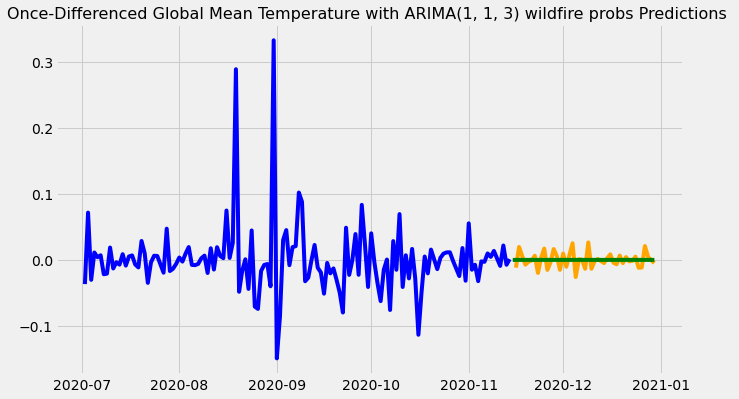

In [42]:
# Instantiate best model.
# MODEL FINISHED!
# Our model that minimizes AIC on the training data is the ARIMA(0,1,1).
# This model has an AIC of -417.3301998053124.
model = ARIMA(endog = y_train.astype(float).dropna(), # endog = Y variable
              order = (0,1,1))

# Fit ARIMA model.
arima = model.fit()

# Generate predictions based on test set.
preds = model.predict(params = arima.params,
                      start = y_test.index[0],
                      end = y_test.index[-1])

# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train).diff(), color = 'blue')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test).diff(), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')
plt.style.use('fivethirtyeight')
plt.title(label = 'Once-Differenced Global Mean Temperature with ARIMA(1, 1, 3) wildfire probs Predictions ', fontsize=16)
plt.show();

In [212]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.proba   No. Observations:                  136
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 211.665
Method:                       css-mle   S.D. of innovations              0.051
Date:                Fri, 27 Aug 2021   AIC                           -417.330
Time:                        16:24:31   BIC                           -408.592
Sample:                    07-02-2020   HQIC                          -413.779
                         - 11-14-2020                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0003      0.004     -0.077      0.939      -0.007       0.007
ma.L1.D.proba    -0.1644      0.085     -1.928      0.054      -0.332       0.003
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            6.0815           +0.0000j            6.0815            0.0000
-----------------------------------------------------------------------------
"""

In [213]:
# using facebook prophet to predict

<AxesSubplot:xlabel='date'>

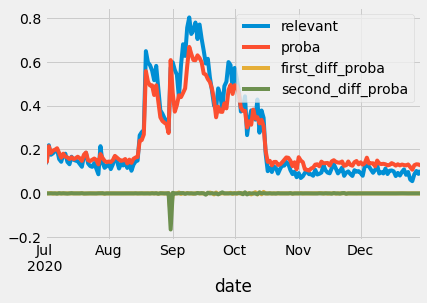

In [43]:
fire2.plot()

In [49]:
fire2.second_diff_proba.sort_values()

date
2020-08-31   -0.164426
2020-09-17   -0.006033
2020-10-07   -0.004905
2020-09-23   -0.004124
2020-10-05   -0.004007
                ...   
2020-09-01    0.002642
2020-09-18    0.003161
2020-10-13    0.004513
2020-09-25    0.004714
2020-10-06    0.004954
Name: second_diff_proba, Length: 183, dtype: float64

In [53]:
# there is outlier, probability much bigger than rest, remove
fire2 = fire2[fire2['second_diff_proba'] != (-0.164426)]

In [57]:
# make new table 
fire2['ds'] = fire2.index
fire2['y'] = fire2.second_diff_proba

fire3 = fire2[['ds', 'y']]
fire3.reset_index(drop=True, inplace=True)
fire3.drop(61,inplace=True) # drop the outlier

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [60]:
fire3.y.sort_values()

78    -0.006033
98    -0.004905
84    -0.004124
96    -0.004007
103   -0.003756
         ...   
62     0.002642
79     0.003161
104    0.004513
86     0.004714
97     0.004954
Name: y, Length: 182, dtype: float64

In [64]:
#instantiate model and fit
model = Prophet(daily_seasonality = True)

model.fit(fire3)
future = model.make_future_dataframe(periods=60)
forecast = model.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.3186
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       215.276   7.68488e-09       100.199      0.3585      0.3585      100   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


,ds,yhat,yhat_lower,yhat_upper
237,2021-02-24,-0.000181,-0.001608,0.001177
238,2021-02-25,-0.000238,-0.001669,0.001030
239,2021-02-26,0.000287,-0.001100,0.001793
240,2021-02-27,-0.000038,-0.001387,0.001402
241,2021-02-28,0.000196,-0.001245,0.001514


Text(0.5, 1.0, 'second diff forecase wildfire by prophet')

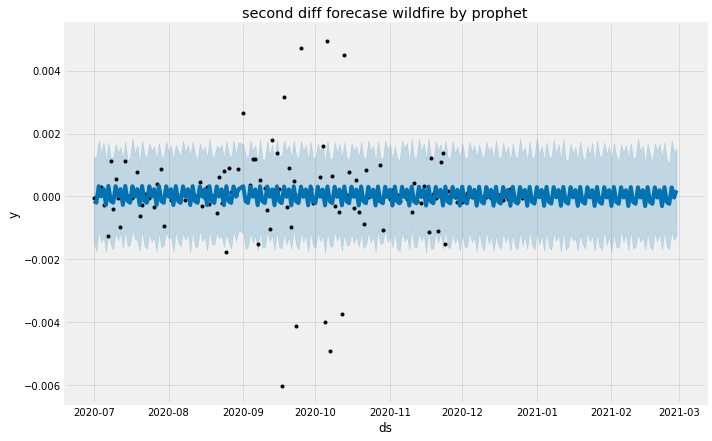

In [68]:
# plot the predict and upper and lower bounds
model.plot(forecast);
plt.title('second diff forecase wildfire by prophet')

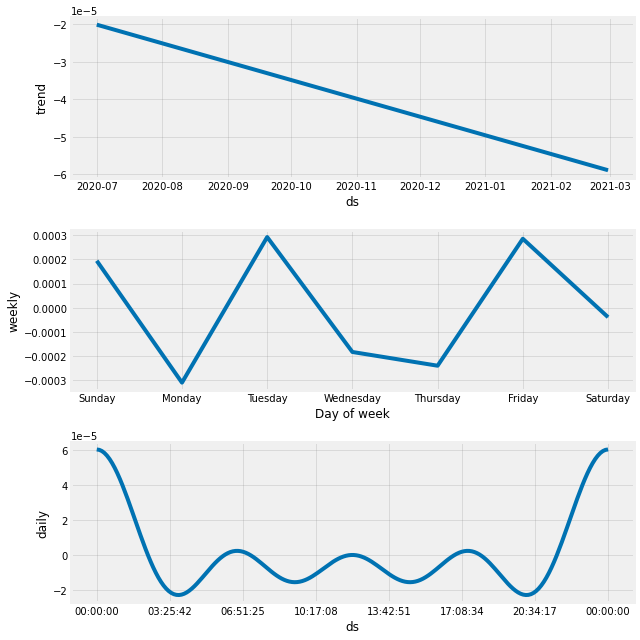

In [69]:
model.plot_components(forecast);